In [1]:
from scipy.integrate import solve_ivp
import numpy as np 

In [2]:
#%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import tikzplotlib

# Lotka-Volterra Model

$x,~y$: prey and predator populations (total mass)

$$
    \begin{bmatrix}
        \dot{x} \\
        \dot{y}
    \end{bmatrix} =
    \begin{bmatrix}
        ax - bxy\\
       -cy + dxy
    \end{bmatrix}
$$

The system is periodic and admits an integral of motion 

$$
    \mathcal{V}(x,y) = -a\ln(y) - c\ln(x) + by + dx 
$$

In [3]:
# Model Parameters
a = 1.  # birth rate preys
b = 1.  # predation effect on preys
c = 1.  # death rate predators
d = 1.  # predation effect on predators

# Control Paramters
xd = 1.  # desired prey's population
yd = 1.  # desired predator's population
#
Kd = .5  # dissipation rate


# Simulation Parameters
x0 = [3,3]  # initial population
ti = 0.     # initial time
tf = 30     # final time

t = np.linspace(ti,tf,1000) # time vector

In [4]:
# Define Model
def ClassicLotkaVolterra(t,x):
    dxdt =  a*x[0] - b*x[0]*x[1]
    dydt = -c*x[1] + d*x[0]*x[1]
    return np.array([dxdt,dydt]).T

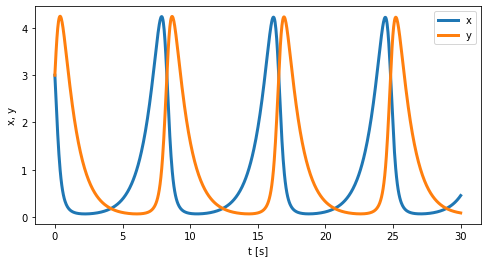

In [5]:
# Integrate ODE
sol = solve_ivp(ClassicLotkaVolterra, [ti, tf], x0, method='LSODA', t_eval=t)

plt.figure(figsize=(8,4));
plt.plot(t,sol.y.T, linewidth=3);
plt.xlabel("t [s]");
plt.ylabel("x, y"); 
plt.legend(["x","y"]);

# Hamiltonian Lotka-Volterra

Change of variables:

$$
    \begin{bmatrix}
        q\\
        p
    \end{bmatrix} =
    \begin{bmatrix}
        \log(y)\\
        \log(x)
    \end{bmatrix}
$$

The Lotka-Volterra model becomes a Hamiltonian system

$$
    \begin{bmatrix}
        \dot{q}\\
        \dot{p}
    \end{bmatrix} =
    \begin{bmatrix}
        0 & 1\\
       -1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        \partial_q \mathcal{H}\\
        \partial_p \mathcal{H}
    \end{bmatrix}
$$
with 
$$
    \mathcal{H}(q,p) = -aq + be^{q} -cp + de^{p}
$$

In [6]:
def HamLotkaVolterra(t,x):
    dqdt = -c + d*np.exp(x[1])
    dpdt =  a - b*np.exp(x[0])
    return np.array([dqdt, dpdt]).T

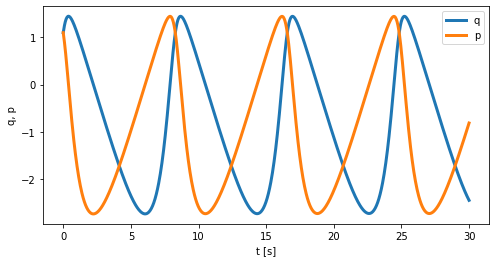

In [7]:
# Integrate ODE
sol = solve_ivp(HamLotkaVolterra, [ti, tf], [np.log(x0[1]),np.log(x0[0])], method='LSODA', t_eval=t)

plt.figure(figsize=(8,4));
plt.plot(t,sol.y.T, linewidth=3);
plt.xlabel("t [s]");
plt.ylabel("q, p");
plt.legend(["q","p"]);

## Compare "Classic" and Hamiltonian Dynamics

- foliation of trajectories
- Shape of the energy/motion integral

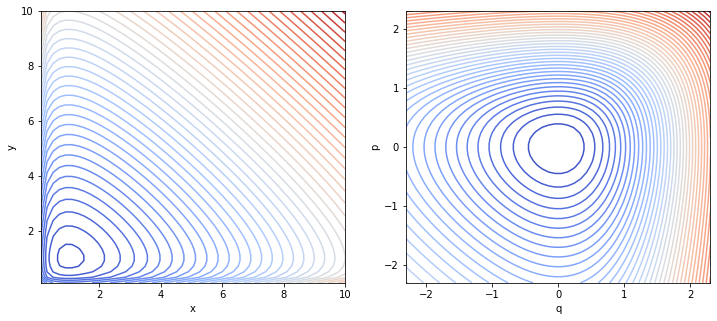

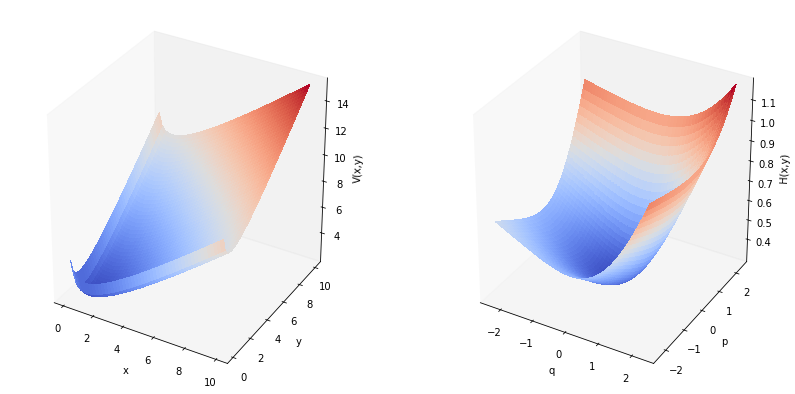

In [8]:
def MotionIntegral(x): return -a*np.log(x[1]) - c*np.log(x[0]) + b*x[1] + d*x[0] 
def Hamiltonian (x):   return -a*x[0] + b*np.exp(x[0]) - c*x[1] + d*np.exp(x[1])

Np = 50
lim = 10
x = np.linspace(0.1, lim, Np)
X, Y = np.meshgrid(x,x)

q = np.linspace(-np.log(lim), np.log(lim), Np)
#q = np.linspace(-5,5, Np)
Q, P = np.meshgrid(q,q)

Vgrid = np.zeros((Np,Np))
Hgrid = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        Vgrid[i,j] = MotionIntegral([X[i,j],Y[i,j]])
        Hgrid[i,j] = np.log10(Hamiltonian([Q[i,j],P[i,j]]))
        
        
fig = plt.figure(figsize=(12,5))
#
ax = fig.add_subplot(121)
surf = ax.contour(X, Y, Vgrid, 50, cmap=cm.coolwarm)
ax.grid(False)
ax.set_xlabel("x");
ax.set_ylabel("y");
#
ax = fig.add_subplot(122)
surf = ax.contour(Q, P, Hgrid, 50, cmap=cm.coolwarm)
ax.grid(False)
ax.set_xlabel("q");
ax.set_ylabel("p");

fig = plt.figure(figsize=(14,7))
#
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, Vgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.grid(False)
ax.set_xlabel("x");
ax.set_ylabel("y");
ax.set_zlabel("V(x,y)");
#
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(Q, P, Hgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.grid(False)
ax.set_xlabel("q");
ax.set_ylabel("p");
ax.set_zlabel("H(x,y)");

#plt.savefig('heyhey.png')

# Controlled System

$$
    \begin{bmatrix}
        \dot{q}\\
        \dot{p}
    \end{bmatrix} =
    \begin{bmatrix}
        0 & 1\\
       -1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        \partial_q \mathcal{H}\\
        \partial_p \mathcal{H}
    \end{bmatrix} + u
$$

The control law $u$ is made up by two distinct actions: the "energy shaping" $\beta$ and the "damping injection" $v$

$$
    u = \beta + v
$$

Feedforward Action (energy shaping):

$$ 
    \beta = 
    \begin{bmatrix}
        dx^* - c\\
        by^* - a
    \end{bmatrix}
$$

Feedback action (damping injection)

$$ 
    v = 
    \begin{bmatrix}
        -K_d\dot{p}\\
        0
    \end{bmatrix},\quad K_d>0
$$

##### In this case, the prey's per-individual birth rate $\dfrac{\dot{x}}{x} = \dot{p}$ is assumed to be measurable/estimated

In [9]:
def ControlLotkaVolterra(t,x):
    dqdt = d*(-xd + np.exp(x[1]))
    dpdt = b*( yd - np.exp(x[0]))
    return np.array([dqdt+Kd*dpdt, dpdt]).T

## Experiment with multiple initial conditions

$N_{\tt sim}$ initial conditions $\mathbf{x}_0^i = [q_0^i,~p_0^i]$ ($i=1,\dots,N_{\tt sim}$) sampled from a Nornal distribution of variance $\sigma$ centered around the desired stable equilibrium point $\mathbf{x}^\star$

$$
    \mathbf{x}_0^i \sim \mathcal{N}(\mathbf{x}^\star,\sigma\mathbb{I})
$$

$N_{\tt sim}$ solutions $\mathbf{x}^i(t)$ have been integrated numerically and plotted

In [10]:
def ControlledHamiltonian(x): return  d*(-xd*x[1] + np.exp(x[1])) + b*(-yd*x[0] + np.exp(x[0]))

In [11]:
SOL_u = [] # underdumped solution
SOL_o = [] # overdamped solution
H_u = []
H_o = []

Nsim = 100
sigma = .75
# Dissipation Rates
Kd_u = .5
Kd_o = 3

t = np.linspace(ti,20,180) # time vector

for i in range(Nsim):
    x0 = sigma*np.random.randn(2)
    Kd = Kd_u
    sol = solve_ivp(ControlLotkaVolterra, [ti, tf], x0, method='LSODA',t_eval=t)
    SOL_u.append(sol.y.T)
    H_u.append([ControlledHamiltonian(p) for p in sol.y.T])
    Kd = Kd_o
    sol = solve_ivp(ControlLotkaVolterra, [ti, tf], x0, method='LSODA',t_eval=t)
    SOL_o.append(sol.y.T)
    H_o.append([ControlledHamiltonian(p) for p in sol.y.T])

In [12]:
Np = 50
u = np.linspace(-2, 2, Np)
U, V = np.meshgrid(u,u)
Hgrid = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        Hgrid[i,j] = np.log10(ControlledHamiltonian([U[i,j],V[i,j]]))

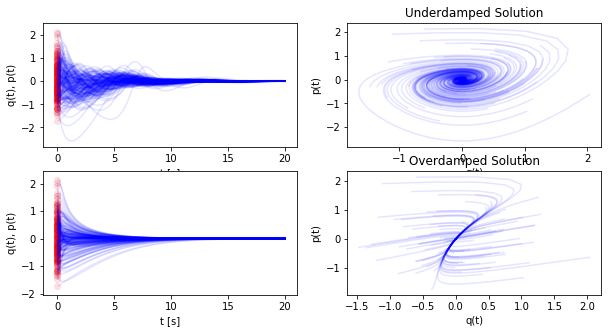

In [13]:
fig = plt.figure(figsize=(10,5))
#
plt.subplot(221)
for i in range(Nsim):
    plt.plot(t,SOL_u[i], color = 'blue', alpha = .1)
for i in range(Nsim):
    plt.scatter([0.,0.],SOL_u[i][0,:], color = 'red', alpha = .1)
plt.xlabel("t [s]")
plt.ylabel("q(t), p(t)");
#
plt.subplot(222)
for i in range(Nsim):
    plt.plot(SOL_u[i][:,0],SOL_u[i][:,1], color = 'blue', alpha = .1)
# for i in range(Nsim):
#     plt.scatter(SOL_u[i][0,0],SOL_u[i][0,1], color = 'red', alpha = .1)
plt.xlabel("q(t)");
plt.ylabel("p(t)");
plt.title('Underdamped Solution')
#
# ax = fig.add_subplot(233, projection='3d')
# for i in range(Nsim):
#     ax.plot(SOL_u[i][:,0],SOL_u[i][:,1],np.log10(H_u[i]),'blue', alpha = .2)
# for i in range(Nsim):
#     ax.scatter(SOL_u[i][0,0],SOL_u[i][0,1],np.log10(H_u[i][0]), color='red', alpha = .2)
#surf = ax.plot_surface(U, V, Hgrid, cmap=cm.summer, linewidth=0, antialiased=False, alpha=.1)
#
plt.subplot(223)
for i in range(Nsim):
    plt.plot(t,SOL_o[i], color = 'blue', alpha = .1)
for i in range(Nsim):
    plt.scatter([0.,0.],SOL_o[i][0,:], color = 'red', alpha = .1)
plt.xlabel("t [s]")
plt.ylabel("q(t), p(t)");
#
plt.subplot(224)
for i in range(Nsim):
    plt.plot(SOL_o[i][:,0],SOL_o[i][:,1], color='blue', alpha = .1)
# for i in range(Nsim):
#     plt.scatter(SOL_o[i][0,0],SOL_o[i][0,1], color ='red', alpha = .1)
plt.xlabel("q(t)");
plt.ylabel("p(t)");
plt.title('Overdamped Solution')
#
# ax = fig.add_subplot(236, projection='3d')
# for i in range(Nsim):
#     ax.plot(SOL_o[i][:,0],SOL_o[i][:,1],np.log10(H_o[i]),color='blue', alpha = .2)
# for i in range(Nsim):
#     ax.scatter(SOL_o[i][0,0],SOL_o[i][0,1],np.log10(H_o[i][0]),color='red', alpha = .2)
#surf = ax.plot_surface(U, V, Hgrid, cmap=cm.summer, linewidth=0, antialiased=False, alpha=.t
tikzplotlib.save('traj_test.tex')

X0_u = np.zeros((Nsim,2))
X0_o = np.zeros((Nsim,2))
for i in range(Nsim):
    X0_u[i] = SOL_u[i][0,:]
    X0_o[i] = SOL_o[i][0,:]
    
np.savetxt('Xu.dat', X0_u, fmt=['%.3f','%.3f'],delimiter='\t',header="x\ty",comments = '')
np.savetxt('Xo.dat', X0_o, fmt=['%.3f','%.3f'],delimiter='\t',header="x\ty",comments = '')

In [14]:
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for i in range(Nsim):
#     ax.plot(SOL_u[i][:,0],SOL_u[i][:,1],np.log10(H_u[i]),color='blue', alpha = .2)
# for i in range(Nsim):
#     ax.scatter(SOL_u[i][0,0],SOL_u[i][0,1],np.log10(H_u[i][0]),color='red', alpha = .2)
#surf = ax.plot_surface(U, V, Hgrid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

tikzplotlib.save('traj_test.tex')

<Figure size 432x288 with 0 Axes>

In [15]:
x0 = [1,1]
X_k = []
T_k = []

N_k = 500
K = np.linspace(0.01,2,N_k)

t = np.linspace(0,20,200)
for i in range(N_k):
    Kd = K[i]
    sol = solve_ivp(ControlLotkaVolterra, [ti, 20], x0, method='LSODA', t_eval=t)
    X_k.append(sol.y.T)
    T_k.append(sol.t)
    
colors = plt.cm.coolwarm(np.linspace(0,1,N_k))

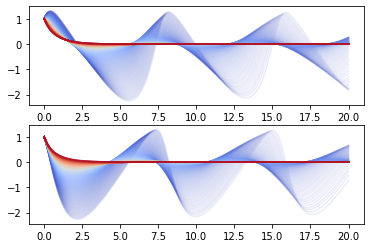

In [16]:


plt.figure()
plt.subplot(211)
for i in range(N_k):
    plt.plot(T_k[i], X_k[i][:,0],color=colors[i], alpha = .1)
plt.subplot(212)
for i in range(N_k):
    plt.plot(T_k[i], X_k[i][:,1],color=colors[i], alpha = .1)
    
tikzplotlib.save('dr_traj_test.tex')

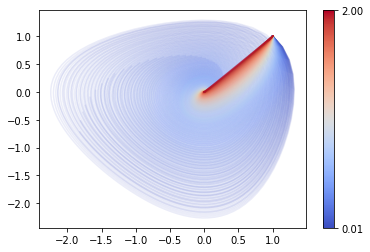

In [17]:
plt.figure()

norm = mpl.colors.Normalize(vmin=K.min(), vmax=K.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

for i in range(N_k):
    plt.plot(X_k[i][:,0],X_k[i][:,1],color=colors[i], alpha = .1)
    
plt.colorbar(cmap, ticks=[K.min(),K.max()])

tikzplotlib.save('dr_ss_test.tex')

In [18]:
def ControlEffort(x): return Kd*ControlLotkaVolterra(0,x)[1]

In [19]:
U_k = []

for i in range(N_k):
    U_k.append([ControlEffort(x) for x in X_k[i]])

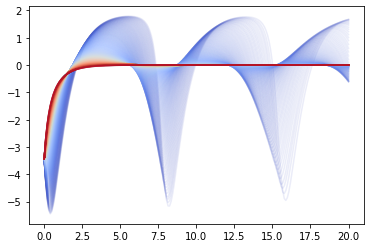

In [20]:
plt.figure()
plt.subplot(111)
for i in range(N_k):
    plt.plot(T_k[i], U_k[i],color=colors[i], alpha = .1)
    
tikzplotlib.save('dr_control_test.tex')

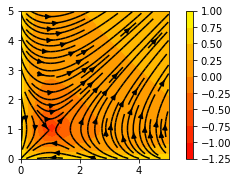

In [21]:
Np_quiver = 20
lim = 5
x = np.linspace(0.01, lim, Np_quiver)
X, Y = np.meshgrid(x,x)

Q, P = np.zeros((Np_quiver,Np_quiver)), np.zeros((Np_quiver,Np_quiver))

for i in range(Np_quiver):
    for j in range(Np_quiver):
        Q[i,j], P[i,j] = np.log(Y[i,j]), np.log(X[i,j])
        
Fmag = np.sqrt(Q**2 + P**2)
dir_x = Q/Fmag
dir_y = P/Fmag

plt.figure(figsize=(8, 6))
plt.subplot(224)
plt.contourf(X, Y, np.log10(Fmag), cmap="autumn")
plt.colorbar()
plt.streamplot(X, Y, Q/Fmag, P/Fmag, color="black")
plt.axis("image")
plt.xlim([0,5]);
plt.ylim([0,5]);

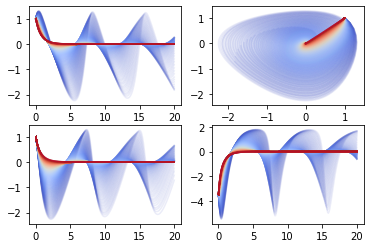

In [22]:
plt.figure()
plt.subplot(221)
for i in range(N_k):
    plt.plot(T_k[i], X_k[i][:,0],color=colors[i], alpha = .1)
plt.subplot(223)
for i in range(N_k):
    plt.plot(T_k[i], X_k[i][:,1],color=colors[i], alpha = .1)
plt.subplot(222)
for i in range(N_k):
    plt.plot(X_k[i][:,0],X_k[i][:,1],color=colors[i], alpha = .1)
plt.subplot(224)
for i in range(N_k):
    plt.plot(T_k[i], U_k[i],color=colors[i], alpha = .1)
    
tikzplotlib.save('dr_traj_test.tex')

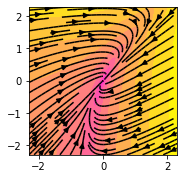

In [68]:
Np_quiver = 100
lim = 10
x = np.linspace(np.log(0.1), np.log(lim), Np_quiver)
Q, P = np.meshgrid(x, x)
dQ, dP = np.zeros((Np_quiver,Np_quiver)), np.zeros((Np_quiver,Np_quiver))

Kd = 2
xd = 1
yd = 1
for i in range(Np_quiver):
    for j in range(Np_quiver):
        dQ[i,j], dP[i,j] = ControlLotkaVolterra(0,[Q[i][j], P[i][j]])
        
Fmag = np.sqrt(dQ**2 + dP**2)

plt.figure(figsize=(8, 6))
plt.subplot(224)
plt.contourf(Q, P, np.log10(Fmag), 10, cmap="spring")
#plt.colorbar()
plt.streamplot(Q, P, dQ/Fmag, dP/Fmag, color="black")
plt.axis("image")
plt.xlim([np.log(0.1), np.log(lim)]);
plt.ylim([np.log(0.1), np.log(lim)]);

tikzplotlib.save('2.tex')